# Generate Dataframe of Incident Status Information

In [5]:
import geopandas as gpd
import pandas as pd
import pickle
import datetime
import numpy as np

from datetime import datetime as dt
from shapely.geometry import Point
from matplotlib import pyplot as plt
from tqdm import tqdm

### 0. Merage Data from Different County
Execute the following code blocks ONLY IF "TSMO_df_inc_raw.pkl" is not available in place

In [3]:
bh_dfs = []
carroll_dfs = []

In [4]:
for i in range(7):
    bh_df = pd.read_csv(f"/Volumes/Hao's WD/TSMO/B&H_Events/ritis-events_{i}.csv")
    bh_dfs.append(bh_df)
    if i > 0:
        carroll_df = pd.read_csv(f"/Volumes/Hao's WD/TSMO/Carroll_Events/ritis-events_Carroll_{i}.csv")
        carroll_dfs.append(carroll_df)

FileNotFoundError: [Errno 2] No such file or directory: "/Volumes/Hao's WD/TSMO/B&H_Events/ritis-events_0.csv"

In [50]:
'''
Index(['Event ID', 'System', 'Agency', 'Standardized Type',
       'Agency-specific Type', 'Agency-specific Sub Type', 'Start time',
       'Closed time', 'Open/Closed', 'Location', 'Op. Center',
       'Detection Source', 'Latitude', 'Longitude', 'Road', 'Direction',
       'County', 'State', 'EDC Incident Type', 'Roadway Clearance Time',
       'Duration (Incident clearance time)', 'Operator Notes',
       'Notifications Sent', 'Responders', 'DMS Used', 'Vehicles Involved',
       'Max Lanes Closed', 'Reliability Score', 'Confidence Score',
       'User Report Rating', 'dt_start'],
      dtype='object')
'''
bh_df_inc_raw = pd.concat(bh_dfs, axis=0)
carroll_df_inc_raw = pd.concat(carroll_dfs, axis=0)
TSMO_df_inc_raw = pd.concat([bh_df_inc_raw, carroll_df_inc_raw], axis=0).reset_index(drop=True)  # (163298, 30)

In [52]:
pickle.dump(TSMO_df_inc_raw, open("./TSMO_df_inc_raw.pkl", "wb"))

### 1. Process Incident Dataframe
- Clean date and time
- Perform spatial join to map incident location to TMC segment(s)

In [9]:
# Hyperparamter
# Time
start_date = dt(2022, 2, 14)
end_date = dt(2023, 2, 12)
start_time = 330 # 05:30:00 
end_time = 1260 # 21:00:00
busi_date = pd.bdate_range(start=start_date, end=end_date).date  # 260 business dates
datetime_index = pd.bdate_range(start=start_date, end=end_date+datetime.timedelta(days=1),freq="5min")  # 104833 = 104832 + 1 = 364*288 + 1

# Shape
TSMO_gdf_tmc = gpd.read_file("../../data/TSMO/TSMO_tmc_shape/TSMO_tmc_shape_for_sjoin.geojson")
TSMO_gdf_tmc = TSMO_gdf_tmc.rename(columns={"tmc":"id_tmc"})
TSMO_gdf_tmc_polygon = TSMO_gdf_tmc.copy()
TSMO_gdf_tmc_polygon["geometry"] = TSMO_gdf_tmc.to_crs(epsg=3857).buffer(distance=10, resolution=1).to_crs(epsg=4326)

In [3]:
TSMO_df_inc_raw = pickle.load(open("./TSMO_df_inc_raw.pkl", "rb"))  # (163298, 30)

#### 1.1 Clean Date and Time

In [4]:
TSMO_df_inc_raw = TSMO_df_inc_raw[~((TSMO_df_inc_raw["Closed time"].isna()) & (TSMO_df_inc_raw["Duration (Incident clearance time)"].isna()))] # (163140, 30)

In [5]:
TSMO_df_inc_raw["dt_start"] = TSMO_df_inc_raw.apply(lambda x: dt.strptime(x["Start time"][:-6], '%Y-%m-%dT%H:%M:%S'), axis=1)
TSMO_df_inc_raw["dt_end"] = TSMO_df_inc_raw.apply(lambda x: dt.strptime(x["Closed time"][:-6], '%Y-%m-%dT%H:%M:%S'), axis=1)
TSMO_df_inc_raw["dt_duration"] = TSMO_df_inc_raw["dt_end"] - TSMO_df_inc_raw["dt_start"]

#### 1.2 Perform spatial join to map incident location to TMC segment(s)

In [6]:
# Note: gpd.GeoDataFrame() is inplace, so I supply TSMO_df_inc_raw.copy() here
gdf_inc_point = gpd.GeoDataFrame(
                    TSMO_df_inc_raw.copy(), crs={'init': 'epsg:4326'},
                    geometry=[Point(xy) for xy in zip(TSMO_df_inc_raw["Longitude"], TSMO_df_inc_raw["Latitude"])]) # (163140, 34)

/Users/haowu/opt/anaconda3/envs/traffic/lib/python3.10/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [8]:
gdf_inc_point = gdf_inc_point[~((gdf_inc_point.Latitude.isna()) | (gdf_inc_point.Longitude.isna()))] # (163139, 34)

<AxesSubplot: >

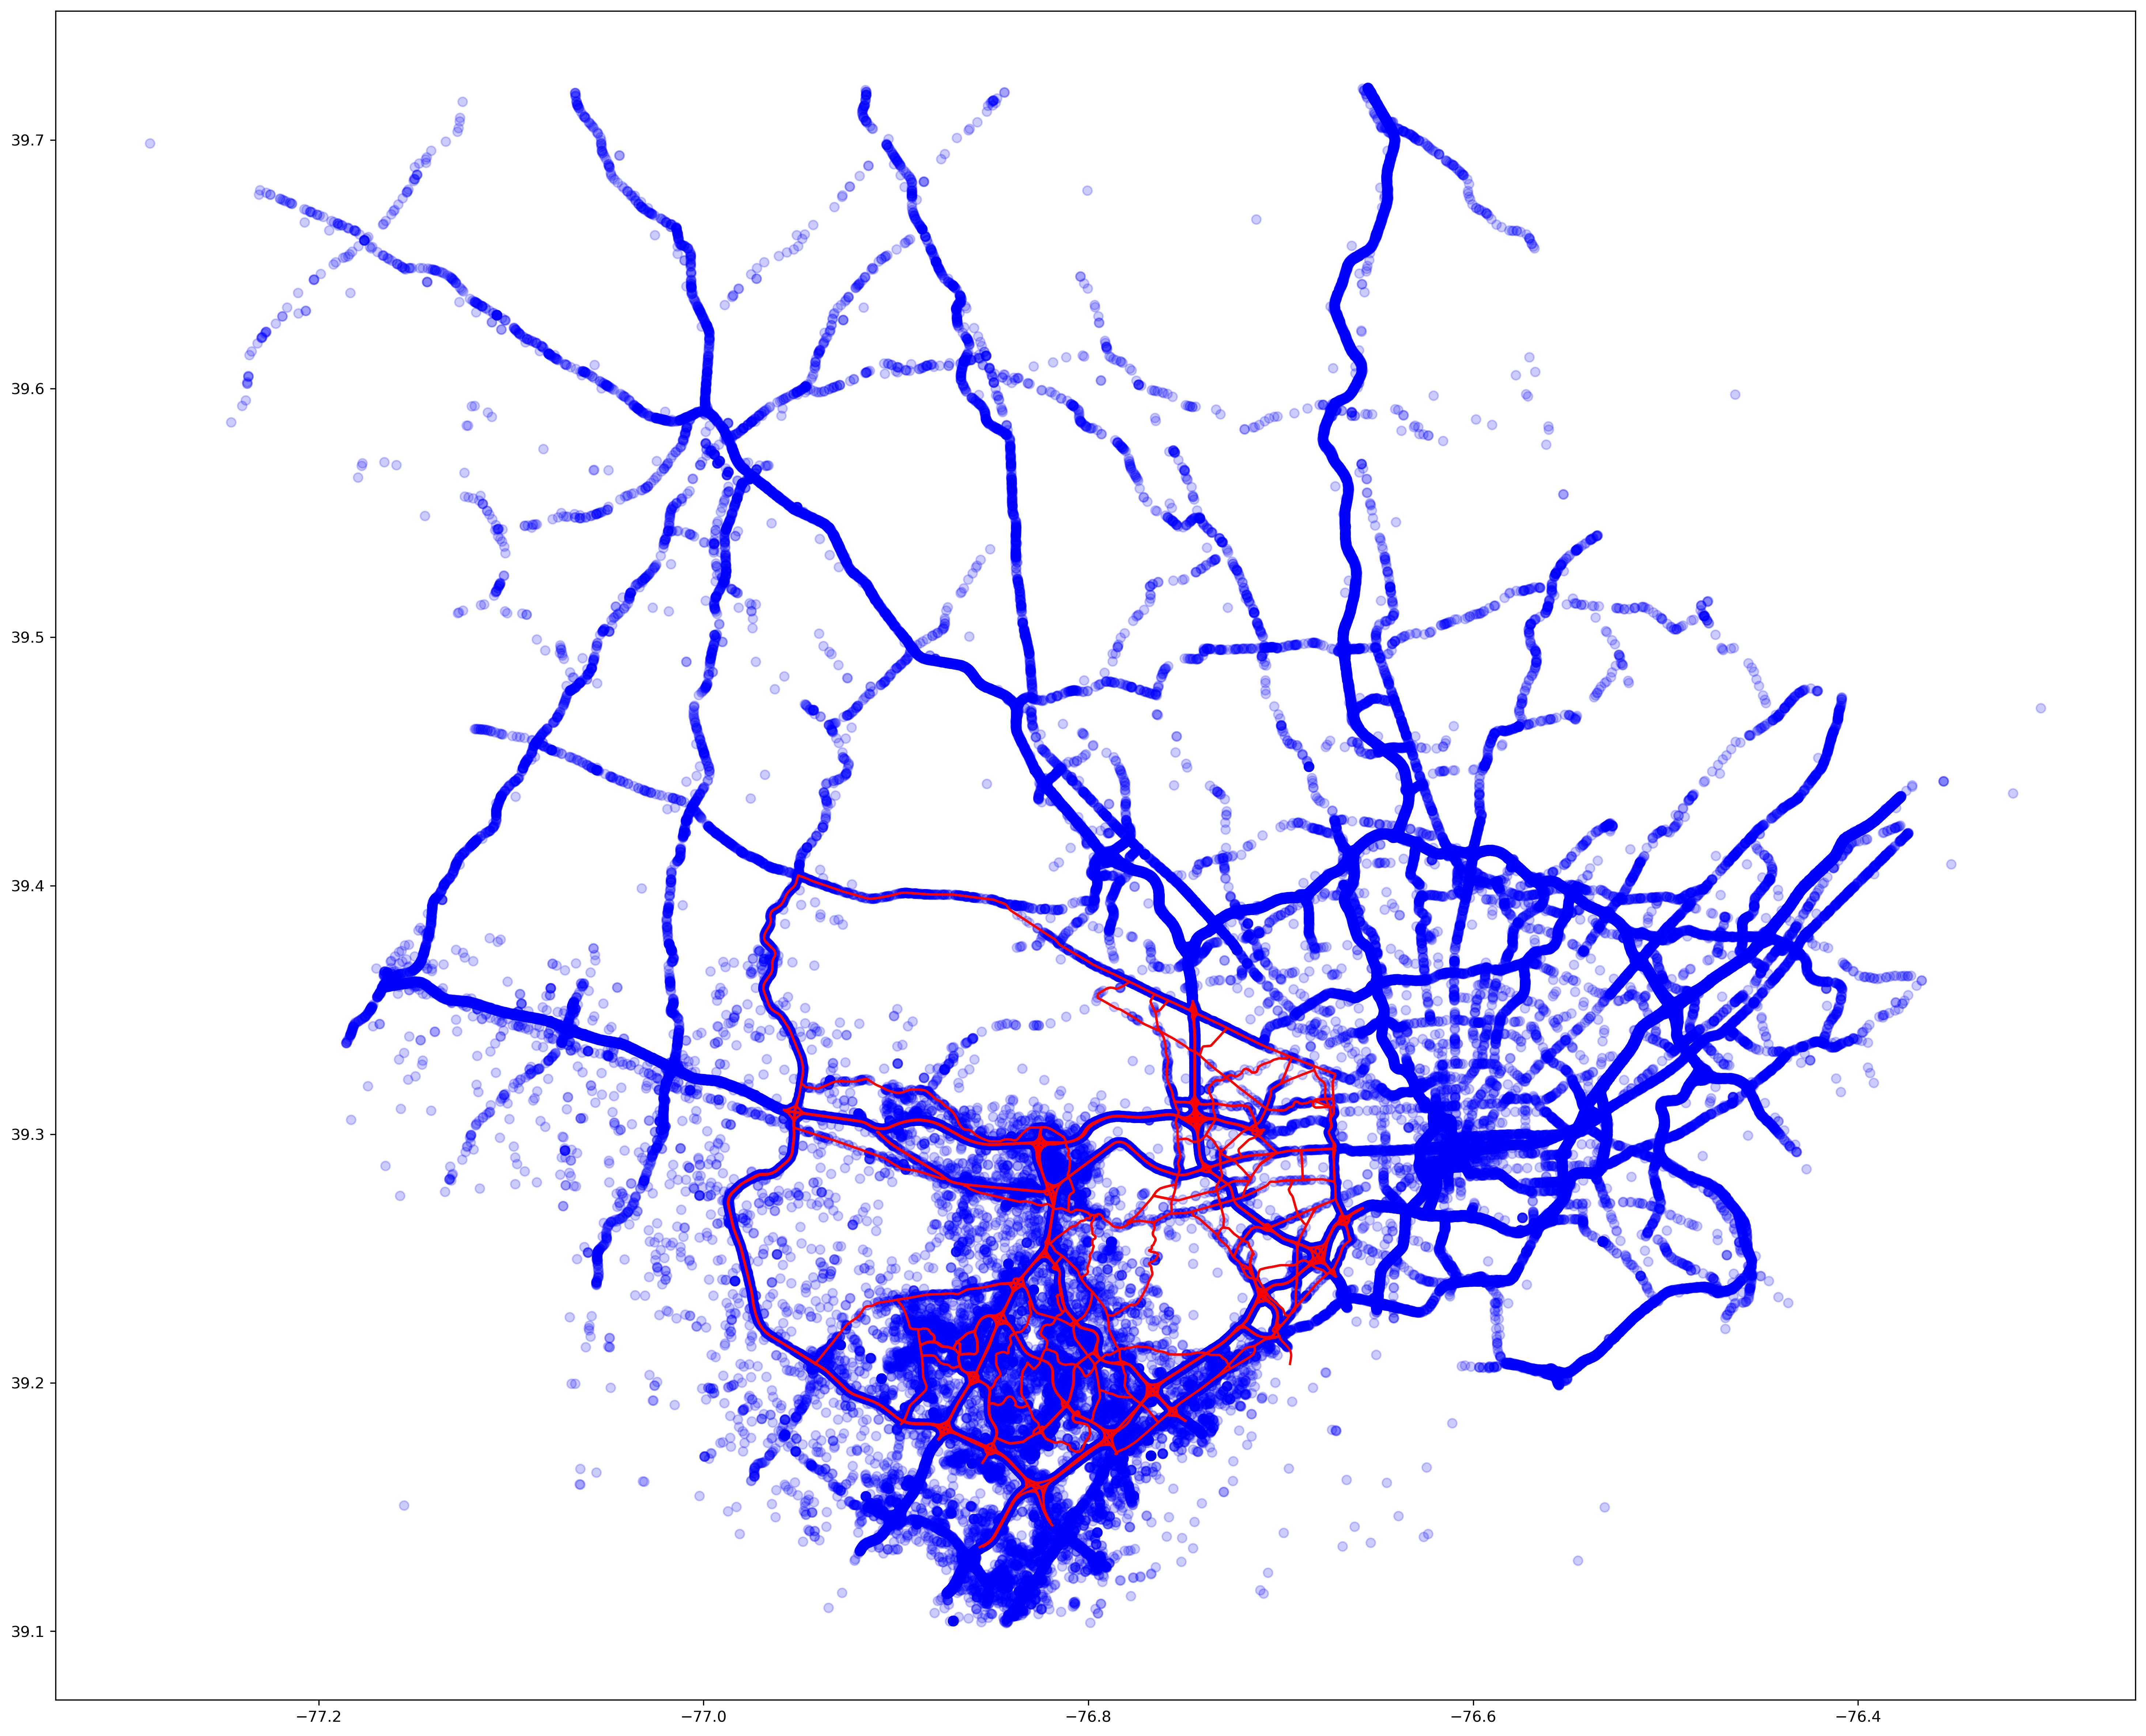

In [11]:
# Visualize Incident Location Points of All Time from Feb 14, 2022 to Feb 12, 2023
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
gdf_inc_point.plot(ax=ax, color="blue", alpha=0.2)
TSMO_gdf_tmc.plot(ax=ax, color = "red")

In [56]:
gdf_inc_point_matched_with_tmc = gpd.sjoin(left_df=gdf_inc_point, right_df=TSMO_gdf_tmc_polygon, how="left", op="within")  # (182482, 52)

/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_42110/2433030765.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  gdf_inc_point_matched_with_tmc = gpd.sjoin(left_df=gdf_inc_point, right_df=TSMO_gdf_tmc_polygon, how="left", op="within")  # (182482, 52)


In [62]:
gdf_inc_record_all = gdf_inc_point_matched_with_tmc[~gdf_inc_point_matched_with_tmc.id_tmc.isna()]  # (65671, 52)

<AxesSubplot: >

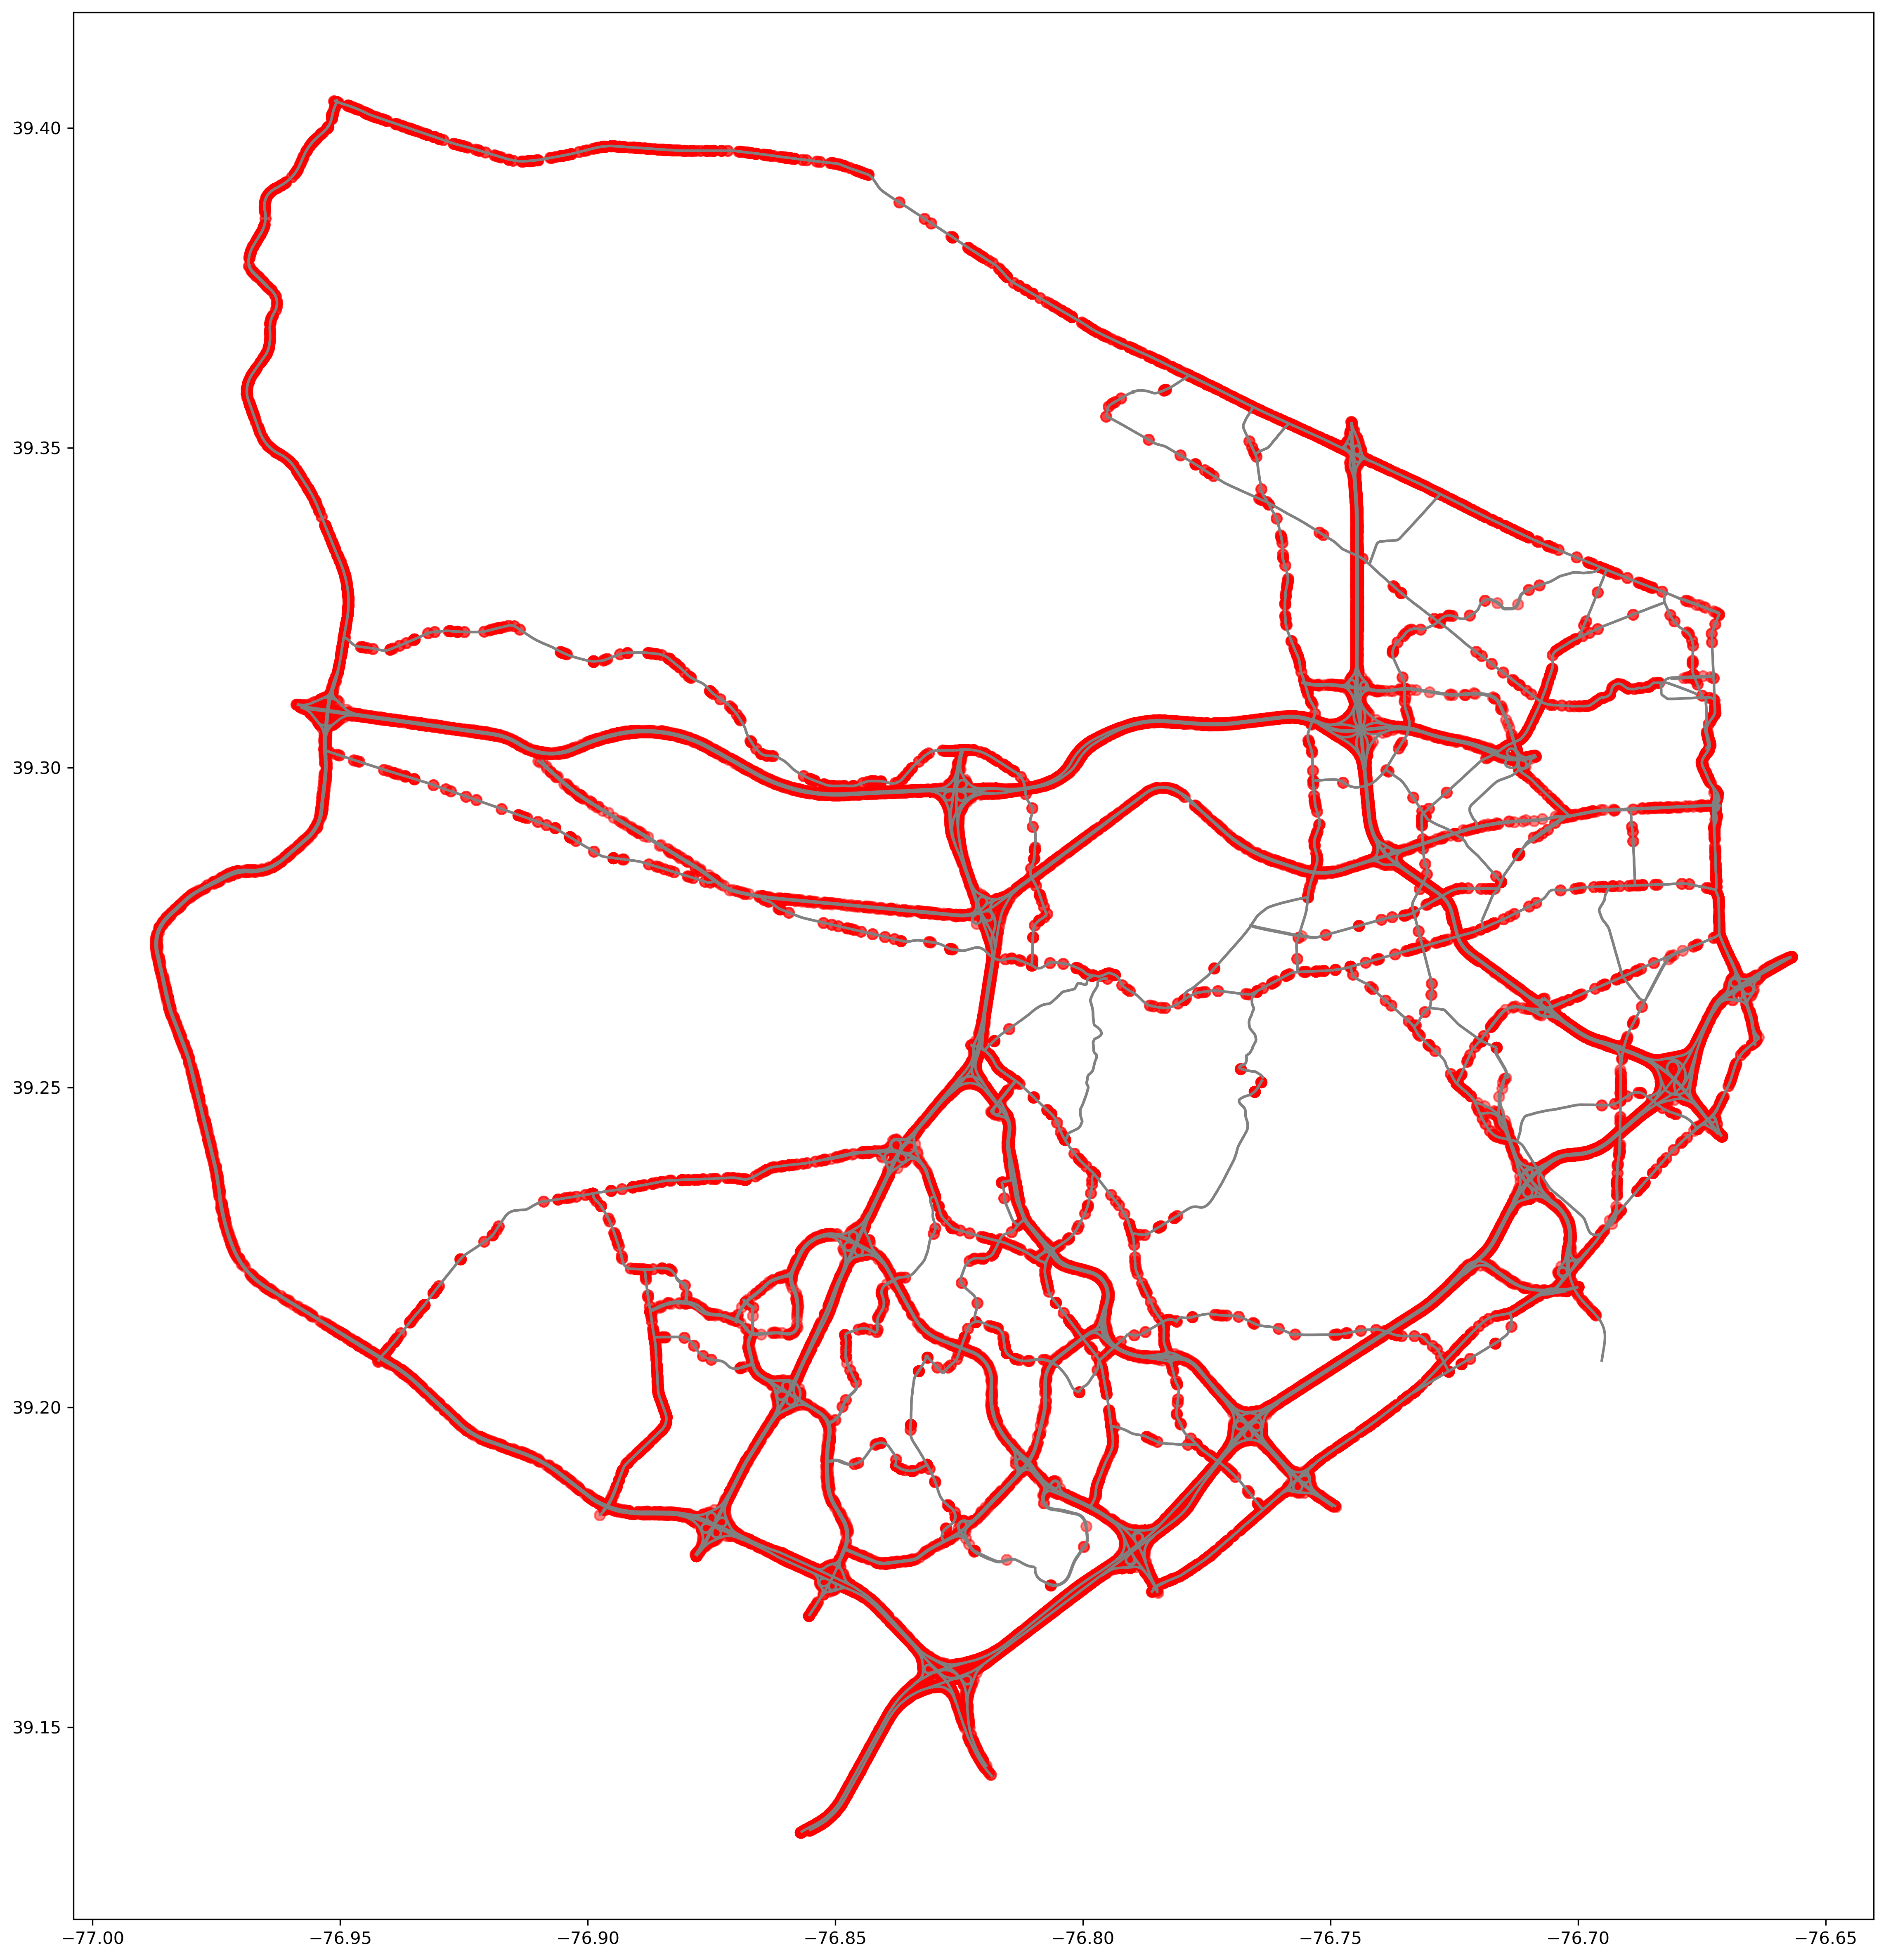

In [63]:
# Visualize Incident Location Points of All Time from Feb 14, 2022 to Feb 12, 2023
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
TSMO_gdf_tmc.plot(ax=ax, color = "grey")
gdf_inc_record_all.plot(ax=ax, color="red", alpha = 0.5)

In [64]:
pickle.dump(gdf_inc_record_all, open("./TSMO_gdf_inc_record_all.pkl", "wb"))

### 2. Finalize Spatial-temporal Dataframe of Incident Status
Make spatial-temporal dataframe of incident status 
- Waze only (with certain type of interest)
- Multi-source max-gated 


In [10]:
gdf_inc_record_all = pickle.load(open("./TSMO_gdf_inc_record_all.pkl", "rb"))

/Users/haowu/opt/anaconda3/envs/traffic/lib/python3.10/site-packages/pyproj/crs/crs.py:292: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [11]:
gdf_inc_record_waze = gdf_inc_record_all[gdf_inc_record_all.System == "Waze"]  # (40217, 52)
gdf_inc_record_non_waze = gdf_inc_record_all[gdf_inc_record_all.System != "Waze"]  # (25454, 52)

In [12]:
# Make sure start and/or end date falls into business dates
gdf_inc_record_waze_filtered_date = gdf_inc_record_waze[
    (gdf_inc_record_waze.dt_start.dt.date.isin(busi_date)) | (gdf_inc_record_waze.dt_end.dt.date.isin(busi_date))
    ]  # (29800, 52)
gdf_inc_record_non_waze_filtered_date = gdf_inc_record_non_waze[
    (gdf_inc_record_non_waze.dt_start.dt.date.isin(busi_date)) | (gdf_inc_record_non_waze.dt_end.dt.date.isin(busi_date))
    ]  # (19431, 52)

# Make sure start and/or end time falls into business hours
gdf_inc_record_waze_filtered_date_time = gdf_inc_record_waze_filtered_date[
                ((gdf_inc_record_waze_filtered_date.dt_start.dt.hour*60 + gdf_inc_record_waze_filtered_date.dt_start.dt.minute >= start_time) & (gdf_inc_record_waze_filtered_date.dt_start.dt.hour*60 + gdf_inc_record_waze_filtered_date.dt_start.dt.minute < end_time)) |
                ((gdf_inc_record_waze_filtered_date.dt_end.dt.hour*60 + gdf_inc_record_waze_filtered_date.dt_end.dt.minute >= start_time) & (gdf_inc_record_waze_filtered_date.dt_end.dt.hour*60 + gdf_inc_record_waze_filtered_date.dt_end.dt.minute < end_time)) 
            ]  # (26984, 52)
gdf_inc_record_non_waze_filtered_date_time = gdf_inc_record_non_waze_filtered_date[
                ((gdf_inc_record_non_waze_filtered_date.dt_start.dt.hour*60 + gdf_inc_record_non_waze_filtered_date.dt_start.dt.minute >= start_time) & (gdf_inc_record_non_waze_filtered_date.dt_start.dt.hour*60 + gdf_inc_record_non_waze_filtered_date.dt_start.dt.minute < end_time)) |
                ((gdf_inc_record_non_waze_filtered_date.dt_end.dt.hour*60 + gdf_inc_record_non_waze_filtered_date.dt_end.dt.minute >= start_time) & (gdf_inc_record_non_waze_filtered_date.dt_end.dt.hour*60 + gdf_inc_record_non_waze_filtered_date.dt_end.dt.minute < end_time)) 
            ]  # (16818, 52)

In [ ]:
pickle.dump(gdf_inc_record_waze_filtered_date_time, open("../data_processing/TSMO/gdf_inc_record_waze_filtered_date_time.pkl", "wb"))
pickle.dump(gdf_inc_record_non_waze_filtered_date_time, open("../data_processing/TSMO/gdf_inc_record_non_waze_filtered_date_time.pkl", "wb"))

#### 2.1 Waze Only

In [13]:
# Exploratory Analysis of Waze Report (type, subtype, reliability score, confidence score)
set(gdf_inc_record_waze["Standardized Type"]), set(gdf_inc_record_waze["Agency-specific Type"]), set(gdf_inc_record_waze["Reliability Score"]), set(gdf_inc_record_waze["Confidence Score"])

({'Animal Struck',
  'Collision',
  'Disabled Vehicle',
  'Flood',
  'Foggy Conditions',
  'Icy Conditions',
  'Incident',
  'Obstructions',
  'Traffic Signal Not Working',
  'Weather Condition'},
 {'Accident', 'Weatherhazard'},
 {6.0, 7.0, 8.0, 9.0, 10.0},
 {0.0, 1.0, 2.0, 3.0, 4.0, 5.0})

In [21]:
df_inc_waze = pd.DataFrame(data=0.0,index=datetime_index,columns=set(TSMO_gdf_tmc.id_tmc))  # (104833, 1591)

In [22]:
df_inc_waze = df_inc_waze[
        (pd.to_datetime(df_inc_waze.index.date).isin(busi_date)) &   # be careful about the syntax here, dealing with index filtering is really annoying
        (df_inc_waze.index.hour*60 + df_inc_waze.index.minute >= start_time) &
        (df_inc_waze.index.hour*60 + df_inc_waze.index.minute < end_time) 
    ]  # (48360, 1591)

In [23]:
df_inc_waze

110P54272  110+09724  110N53843  110-05026  110+53833  \
2022-02-14 05:30:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:35:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:40:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:45:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:50:00        0.0        0.0        0.0        0.0        0.0   
...                        ...        ...        ...        ...        ...   
2023-02-10 20:35:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:40:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:45:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:50:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:55:00        0.0        0.0        0.0        0.0        0.0   

                     110+50429  110N05038  110P53855  110N12377  110+52780  \
2022-02-14 05:30:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:35:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:40:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:45:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:50:00        0.0        0.0        0.0        0.0        0.0   
...                        ...        ...        ...        ...        ...   
2023-02-10 20:35:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:40:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:45:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:50:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:55:00        0.0        0.0        0.0        0.0        0.0   

                     ...  110-12374  110P55273  110P11760  110N12719  \
2022-02-14 05:30:00  ...        0.0        0.0        0.0        0.0   
2022-02-14 05:35:00  ...        0.0        0.0        0.0        0.0   
2022-02-14 05:40:00  ...        0.0        0.0        0.0        0.0   
2022-02-14 05:45:00  ...        0.0        0.0        0.0        0.0   
2022-02-14 05:50:00  ...        0.0        0.0        0.0        0.0   
...                  ...        ...        ...        ...        ...   
2023-02-10 20:35:00  ...        0.0        0.0        0.0        0.0   
2023-02-10 20:40:00  ...        0.0        0.0        0.0        0.0   
2023-02-10 20:45:00  ...        0.0        0.0        0.0        0.0   
2023-02-10 20:50:00  ...        0.0        0.0        0.0        0.0   
2023-02-10 20:55:00  ...        0.0        0.0        0.0        0.0   

                     110-09716  110+05034  110P55291  110N05140  110N04521  \
2022-02-14 05:30:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:35:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:40:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:45:00        0.0        0.0        0.0        0.0        0.0   
2022-02-14 05:50:00        0.0        0.0        0.0        0.0        0.0   
...                        ...        ...        ...        ...        ...   
2023-02-10 20:35:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:40:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:45:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:50:00        0.0        0.0        0.0        0.0        0.0   
2023-02-10 20:55:00        0.0        0.0        0.0        0.0        0.0   

                     110P14985  
2022-02-14 05:30:00        0.0  
2022-02-14 05:35:00        0.0  
2022-02-14 05:40:00        0.0  
2022-02-14 05:45:00        0.0  
2022-02-14 05:50:00        0.0  
...                        ...  
2023-02-10 20:35:00        0.0  
2023-02-10 20:40:00        0.0  
2023-02-10 20:45:00        0.0  
2023-02-10 20:5

In [24]:
for i in tqdm(range(len(gdf_inc_record_waze_filtered_date_time))):
    start = gdf_inc_record_waze_filtered_date_time.iloc[i].dt_start
    end = gdf_inc_record_waze_filtered_date_time.iloc[i].dt_end
    id_tmc = gdf_inc_record_waze_filtered_date_time.iloc[i].id_tmc
    # df_inc_waze[(df_inc_waze.index >= start) & (df_inc_waze.index < end)][id_tmc] = 1.0 # this won't work as it will return a view instead of changing value in place
    df_inc_waze.loc[(df_inc_waze.index >= start) & (df_inc_waze.index <= end), id_tmc] = 1.0

100%|██████████| 26984/26984 [00:09<00:00, 2731.56it/s]


### 2.2 Multi-source max-gated

In [25]:
df_inc_all = df_inc_waze.copy()

In [26]:
for i in tqdm(range(len(gdf_inc_record_non_waze_filtered_date_time))):
    start = gdf_inc_record_non_waze_filtered_date_time.iloc[i].dt_start
    end = gdf_inc_record_non_waze_filtered_date_time.iloc[i].dt_end
    id_tmc = gdf_inc_record_non_waze_filtered_date_time.iloc[i].id_tmc
    df_inc_all.loc[(df_inc_all.index >= start) & (df_inc_all.index <= end), id_tmc] = 2.0

100%|██████████| 16818/16818 [00:06<00:00, 2795.33it/s]


In [27]:
pickle.dump(df_inc_waze, open("./TSMO_df_inc_tmc_5min_waze.pkl", "wb"))
pickle.dump(df_inc_all, open("./TSMO_df_inc_tmc_5min_all.pkl", "wb"))